In [65]:
import datetime
import numpy as np
import pandas_datareader as pdr
import esig
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import base
from utils import tosig
from utils.leadlag import leadlag
from rough_bergomi import rough_bergomi

from importlib import reload
import cvae_keras
reload(cvae_keras)
import cvae_tfp
reload(cvae_tfp)

import matplotlib.pyplot as plt

## Data processing

In [66]:
# # S&P 500
# data = pdr.get_data_yahoo("^GSPC", datetime.date(2000, 1, 1), datetime.date(2019, 1, 1))["Close"]
# windows = []
# for _, window in data.resample('M'):
#     values = window.values
#     path = leadlag(values)
#     windows.append(path)

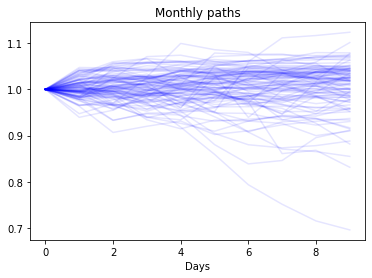

In [67]:
# Actually for rough_bergomi model, conditional VAE does no help because the cond are independent

# rough_bergomi
params = {
            "M": 100,
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.1,
            "nu": 1.5,
            "S0": 10.
          }

params2 = {
            "M": 100,
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.2,
            "nu": 1,
            "S0": 10.
          }

def _load_rough_bergomi(params, freq, test_use = False):
    grid_points_dict = {"M": 28, "W": 10, "Y": 252}
    grid_points = grid_points_dict[freq]
    params["T"] = grid_points / grid_points_dict["Y"]
    paths = rough_bergomi(grid_points, **params)
    if test_use:
        windows = paths
    else:   
        windows = [leadlag(path) for path in paths]
    return windows

windows = _load_rough_bergomi(params, 'W')

for path in windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.1)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

In [4]:
windows_aug = _load_rough_bergomi(params, 'W', True)
helper = np.tile(np.arange(10)/10, [100,1])
windows = np.concatenate([helper[:,:,None], windows_aug[:,:,None]],axis = -1)

## Log-signature computing

In [5]:
order = 4
def _logsig(path):
    return esig.tosig.stream2logsig(path, order)
def _sig(path):
    return esig.tosig.stream2sig(path, order)

train_windows = _load_rough_bergomi(params, 'M')
train_logsig = np.array([_logsig(path) for path in tqdm(train_windows, desc="Computing log-signatures")])
train_sig = np.array([_sig(path) for path in tqdm(train_windows, desc="Computing signatures")])

test_windows = _load_rough_bergomi(params, 'M')
test_logsig = np.array([_logsig(path) for path in tqdm(test_windows, desc="Computing log-signatures")])
test_sig = np.array([_sig(path) for path in tqdm(test_windows, desc="Computing signatures")])

scaler_logsig = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig_transformed = scaler_logsig.fit_transform(train_logsig)

scaler_sig = MinMaxScaler(feature_range=(0.00001, 0.99999))
sig_transformed = scaler_sig.fit_transform(train_sig)

data = logsig_transformed[1:]   # 1 week forecasting 1 week 
data_cond = logsig_transformed[:-1] 
scaler = scaler_logsig

# data = sig_transformed[1:]   # 1 week forecasting 1 week 
# data_cond = sig_transformed[:-1] 
# scaler = scaler_sig

## CVAE

In [6]:
# Standard normal (tfp)
reload(cvae_tfp)
sample_dim = data.shape[0]
data_dim = data.shape[-1]
cond_dim = data_cond.shape[-1]
latent_dim = 8
hidden_dim = 50
weight = 0.003

x_input = [data, data_cond]
encoder = cvae_tfp.Encoder(data_dim, cond_dim, latent_dim, hidden_dim)
sampler = cvae_tfp.NormalSampler(latent_dim)
encodersampler = cvae_tfp.EncoderSampler(encoder,sampler)
decoder = cvae_tfp.Decoder(data_dim, cond_dim, latent_dim, hidden_dim)
model_normal = cvae_tfp.CVAE_bergomi(data_dim, cond_dim, latent_dim, hidden_dim, weight, decoder, encodersampler, False)
model_normal.compile(optimizer='adam', loss=cvae_tfp.zero_error)
model_normal.fit(x = x_input, y = data, epochs=10000,batch_size=sample_dim, verbose = True)

normalised_generated1 = model_normal.generate(data_cond)

Epoch 1/10000
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
1/1 [==============================] - 2s 2s/step - loss: 0.9861
Epoch 2/10000
1/1 [==============================] - 0s 14ms/step - loss: 0.9501
Epoch 3/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.9013
Epoch 4/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.8355
Epoch 5/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.7761
Epoch 6/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.7340
Epoch 7/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.6818
Epoch 8/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.6344
Epoch 9/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.6305
Epoch 10/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.5839
Epoch 11/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.5550
Epoch 12/10000
1/1 [===========

Epoch 197/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0861
Epoch 198/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0908
Epoch 199/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0890
Epoch 200/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0887
Epoch 201/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0937
Epoch 202/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0897
Epoch 203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0755
Epoch 204/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0815
Epoch 205/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0875
Epoch 206/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1032
Epoch 207/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0821
Epoch 208/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0842
Epoch 209/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0451
Epoch 397/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0416
Epoch 398/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0422
Epoch 399/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0422
Epoch 400/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 401/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0420
Epoch 402/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0417
Epoch 403/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0424
Epoch 404/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0409
Epoch 405/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0429
Epoch 406/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0420
Epoch 407/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0420
Epoch 408/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0430
Epoch 497/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0399
Epoch 498/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 499/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0401
Epoch 500/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0389
Epoch 501/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0386
Epoch 502/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0416
Epoch 503/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 504/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0393
Epoch 505/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 506/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 507/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0413
Epoch 508/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0394
Epoch 597/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 598/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0368
Epoch 599/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 600/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0373
Epoch 601/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0373
Epoch 602/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0382
Epoch 603/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0378
Epoch 604/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0393
Epoch 605/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0380
Epoch 606/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 607/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0369
Epoch 608/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch 697/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0348
Epoch 698/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 699/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 700/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 701/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0355
Epoch 702/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0361
Epoch 703/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0365
Epoch 704/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 705/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0371
Epoch 706/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0365
Epoch 707/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0359
Epoch 708/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0334
Epoch 797/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0342
Epoch 798/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0335
Epoch 799/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0337
Epoch 800/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0337
Epoch 801/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0384
Epoch 802/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 803/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0357
Epoch 804/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0350
Epoch 805/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0356
Epoch 806/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0346
Epoch 807/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0371
Epoch 808/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0299
Epoch 897/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 898/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0322
Epoch 899/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0294
Epoch 900/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0306
Epoch 901/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 902/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 903/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 904/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 905/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0295
Epoch 906/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0287
Epoch 907/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 908/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0273
Epoch 997/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0288
Epoch 998/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0291
Epoch 999/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0269
Epoch 1000/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 1001/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 1002/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0258
Epoch 1003/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 1004/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 1005/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 1006/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 1007/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0258
Epoch 1008/10000
1/1 [==

1/1 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 1193/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 1194/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 1195/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 1196/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0215
Epoch 1197/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 1198/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 1199/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 1200/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 1201/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0226
Epoch 1202/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 1203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 1204/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 1389/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0220
Epoch 1390/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 1391/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 1392/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 1393/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 1394/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 1395/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 1396/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 1397/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0211
Epoch 1398/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 1399/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 1400/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 1585/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 1586/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 1587/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0200
Epoch 1588/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 1589/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 1590/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 1591/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 1592/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 1593/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 1594/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch 1595/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0196
Epoch 1596/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 1781/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 1782/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 1783/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 1784/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0192
Epoch 1785/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 1786/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 1787/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 1788/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 1789/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 1790/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 1791/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 1792/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 1977/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 1978/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 1979/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 1980/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 1981/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 1982/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 1983/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 1984/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 1985/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 1986/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 1987/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 1988/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 2173/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 2174/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 2175/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 2176/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 2177/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 2178/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 2179/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 2180/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 2181/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 2182/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 2183/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 2184/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 2369/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 2370/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 2371/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 2372/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 2373/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 2374/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 2375/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 2376/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 2377/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 2378/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 2379/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 2380/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 2565/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 2566/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 2567/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 2568/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 2569/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 2570/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 2571/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2572/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 2573/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 2574/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 2575/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 2576/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 2761/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 2762/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 2763/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 2764/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 2765/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 2766/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 2767/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 2768/10000
1/1 [==============================] - 0s 995us/step - loss: 0.0179
Epoch 2769/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 2770/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 2771/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 2772/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 2957/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 2958/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 2959/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 2960/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2961/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 2962/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 2963/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 2964/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 2965/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 2966/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 2967/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 2968/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3153/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3154/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 3155/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 3156/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 3157/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3158/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3159/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 3160/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 3161/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3162/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3163/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 3164/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3349/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 3350/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 3351/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 3352/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3353/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3354/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 3355/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3356/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 3357/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3358/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3359/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 3360/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3545/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 3546/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3547/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 3548/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3549/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 3550/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3551/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 3552/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 3553/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3554/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 3555/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3556/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 3741/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 3742/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 3743/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 3744/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 3745/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 3746/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 3747/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 3748/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 3749/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 3750/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0144
Epoch 3751/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 3752/10000
1/

1/1 [==============================] - 0s 998us/step - loss: 0.0138
Epoch 3937/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3938/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 3939/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 3940/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 3941/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 3942/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 3943/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0144
Epoch 3944/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 3945/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 3946/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 3947/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3948/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4133/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 4134/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4135/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4136/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 4137/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 4138/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 4139/10000
1/1 [==============================] - 0s 996us/step - loss: 0.0137
Epoch 4140/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4141/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 4142/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4143/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 4144/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 4329/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 4330/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4331/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 4332/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 4333/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4334/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4335/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 4336/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4337/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 4338/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 4339/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 4340/10000
1/1 

1/1 [==============================] - 0s 999us/step - loss: 0.0137
Epoch 4525/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4526/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 4527/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 4528/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 4529/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4530/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4531/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 4532/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 4533/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 4534/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 4535/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4536/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 4721/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4722/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 4723/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 4724/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 4725/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4726/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 4727/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 4728/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 4729/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 4730/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 4731/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0143
Epoch 4732/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4917/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 4918/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4919/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4920/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 4921/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 4922/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 4923/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 4924/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 4925/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4926/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 4927/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 4928/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5113/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5114/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5115/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5116/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5117/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5118/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5119/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 5120/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5121/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5122/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 5123/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 5124/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5309/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 5310/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5311/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5312/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0126
Epoch 5313/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5314/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 5315/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 5316/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5317/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5318/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0132
Epoch 5319/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5320/10000


1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5505/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5506/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5507/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5508/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5509/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 5510/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 5511/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 5512/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5513/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5514/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 5515/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5516/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5701/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5702/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 5703/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 5704/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5705/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5706/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 5707/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5708/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5709/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 5710/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5711/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0128
Epoch 5712/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5897/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 5898/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 5899/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 5900/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5901/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5902/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5903/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5904/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 5905/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 5906/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5907/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5908/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6093/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 6094/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6095/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6096/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6097/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6098/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6099/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 6100/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6101/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 6102/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6103/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6104/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 6289/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6290/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0127
Epoch 6291/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6292/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 6293/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6294/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6295/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6296/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6297/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6298/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6299/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 6300/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6485/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6486/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 6487/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6488/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 6489/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 6490/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6491/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6492/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6493/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6494/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 6495/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6496/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 6681/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6682/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6683/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6684/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 6685/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 6686/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6687/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6688/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 6689/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6690/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6691/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6692/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 6877/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6878/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0125
Epoch 6879/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6880/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 6881/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6882/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6883/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6884/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 6885/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6886/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 6887/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6888/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7073/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 7074/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7075/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7076/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 7077/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7078/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7079/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7080/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 7081/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7082/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 7083/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 7084/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7269/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7270/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7271/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7272/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 7273/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7274/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7275/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0118
Epoch 7276/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7277/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7278/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 7279/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 7280/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7465/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7466/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 7467/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7468/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7469/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 7470/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 7471/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 7472/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 7473/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 7474/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7475/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7476/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7661/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7662/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7663/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 7664/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7665/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 7666/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 7667/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 7668/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 7669/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 7670/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7671/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7672/10000
1/1 

1/1 [==============================] - 0s 998us/step - loss: 0.0116
Epoch 7857/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 7858/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 7859/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 7860/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 7861/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 7862/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 7863/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7864/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7865/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7866/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7867/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 7868/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8053/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8054/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 8055/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 8056/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8057/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 8058/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 8059/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 8060/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8061/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 8062/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8063/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 8064/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8249/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8250/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8251/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 8252/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 8253/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8254/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8255/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 8256/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0116
Epoch 8257/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 8258/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8259/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8260/10000
1/

1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 8445/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8446/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8447/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 8448/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 8449/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 8450/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 8451/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 8452/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 8453/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8454/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 8455/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 8456/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 8641/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8642/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 8643/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 8644/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 8645/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8646/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8647/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8648/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8649/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 8650/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 8651/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8652/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 8837/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8838/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 8839/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 8840/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 8841/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 8842/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 8843/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 8844/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8845/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 8846/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 8847/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 8848/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9033/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 9034/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 9035/10000
1/1 [==============================] - 0s 997us/step - loss: 0.0115
Epoch 9036/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9037/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9038/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 9039/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9040/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 9041/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9042/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9043/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9044/10000
1/

1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9229/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9230/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 9231/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9232/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 9233/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9234/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9235/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9236/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 9237/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 9238/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9239/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9240/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 9425/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 9426/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 9427/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 9428/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9429/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9430/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 9431/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9432/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 9433/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 9434/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 9435/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 9436/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 9621/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 9622/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9623/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9624/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9625/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9626/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 9627/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9628/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9629/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9630/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 9631/10000
1/1 [==============================] - 0s 1000us/step - loss: 0.0118
Epoch 9632/10000
1

1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9817/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9818/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9819/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9820/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9821/10000
1/1 [==============================] - 0s 998us/step - loss: 0.0114
Epoch 9822/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 9823/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 9824/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 9825/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9826/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 9827/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9828/10000
1/

In [7]:
generated_logsig1 = scaler.inverse_transform(normalised_generated1)
generated_sig1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig1)])

# generated_sig1 = scaler.inverse_transform(normalised_generated1)
# generated_logsig1 = np.array([tosig.sig2logsig(sig, 2, order) for sig in tqdm(generated_sig1)])

In [8]:
# Student-t (tfp)
reload(cvae_tfp)
sample_dim = data.shape[0]
data_dim = data.shape[-1]
cond_dim = data_cond.shape[-1]
latent_dim = 8
hidden_dim = 50
weight = 0.003

x_input = [data, data_cond]
encoder = cvae_tfp.Encoder_Pseudo(data_dim, cond_dim, latent_dim, hidden_dim)
sampler = cvae_tfp.StudentSampler(latent_dim)
encodersampler = cvae_tfp.EncoderSampler(encoder,sampler)
decoder = cvae_tfp.Decoder(data_dim, cond_dim, latent_dim, hidden_dim)
model_student = cvae_tfp.CVAE_bergomi(data_dim, cond_dim, latent_dim, hidden_dim, weight, decoder, encodersampler, False)
model_student.compile(optimizer='adam', loss=cvae_tfp.zero_error)
model_student.fit(x = x_input, y = data, epochs=10000,batch_size=sample_dim, verbose = True)

normalised_generated2 = model_student.generate(data_cond)
generated_logsig2 = scaler.inverse_transform(normalised_generated2)
generated_sig2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig2)])

Epoch 1/10000
1/1 [==============================] - 2s 2s/step - loss: 1.4643
Epoch 2/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.4119
Epoch 3/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.2338
Epoch 4/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.3828
Epoch 5/10000
1/1 [==============================] - 0s 2ms/step - loss: 1.1295
Epoch 6/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.9922
Epoch 7/10000
1/1 [==============================] - 0s 3ms/step - loss: 1.0791
Epoch 8/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.8973
Epoch 9/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.9531
Epoch 10/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.8696
Epoch 11/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.8260
Epoch 12/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.7795
Epoch 13/10000
1/1 [==================

1/1 [==============================] - 0s 3ms/step - loss: 0.1148
Epoch 203/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1381
Epoch 204/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1270
Epoch 205/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1211
Epoch 206/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1327
Epoch 207/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1245
Epoch 208/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1175
Epoch 209/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1185
Epoch 210/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1252
Epoch 211/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1222
Epoch 212/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.1266
Epoch 213/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.1174
Epoch 214/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0859
Epoch 303/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0901
Epoch 304/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0917
Epoch 305/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0841
Epoch 306/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0960
Epoch 307/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0825
Epoch 308/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0904
Epoch 309/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0838
Epoch 310/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0833
Epoch 311/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0799
Epoch 312/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0836
Epoch 313/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0891
Epoch 314/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 403/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0565
Epoch 404/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0581
Epoch 405/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0596
Epoch 406/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0583
Epoch 407/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0597
Epoch 408/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0577
Epoch 409/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0573
Epoch 410/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0584
Epoch 411/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0592
Epoch 412/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0557
Epoch 413/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0562
Epoch 414/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0484
Epoch 503/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0494
Epoch 504/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0462
Epoch 505/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0480
Epoch 506/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0492
Epoch 507/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0491
Epoch 508/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0473
Epoch 509/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0457
Epoch 510/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0444
Epoch 511/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0475
Epoch 512/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0486
Epoch 513/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0447
Epoch 514/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0446
Epoch 603/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0466
Epoch 604/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0440
Epoch 605/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0423
Epoch 606/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0438
Epoch 607/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0451
Epoch 608/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0439
Epoch 609/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0430
Epoch 610/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0462
Epoch 611/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0461
Epoch 612/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0436
Epoch 613/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0422
Epoch 614/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 703/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0403
Epoch 704/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0445
Epoch 705/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0390
Epoch 706/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0412
Epoch 707/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0432
Epoch 708/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0400
Epoch 709/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0400
Epoch 710/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0405
Epoch 711/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0413
Epoch 712/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0398
Epoch 713/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0399
Epoch 714/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0393
Epoch 803/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0384
Epoch 804/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0389
Epoch 805/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0396
Epoch 806/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0398
Epoch 807/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0391
Epoch 808/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0380
Epoch 809/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 810/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 811/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0389
Epoch 812/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0388
Epoch 813/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0397
Epoch 814/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0377
Epoch 903/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0386
Epoch 904/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 905/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0382
Epoch 906/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0360
Epoch 907/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0382
Epoch 908/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0377
Epoch 909/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 910/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0394
Epoch 911/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0387
Epoch 912/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0379
Epoch 913/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 914/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 1003/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0357
Epoch 1004/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0356
Epoch 1005/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0366
Epoch 1006/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0378
Epoch 1007/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0356
Epoch 1008/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0365
Epoch 1009/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0369
Epoch 1010/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0377
Epoch 1011/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0378
Epoch 1012/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0348
Epoch 1013/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0349
Epoch 1014/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0321
Epoch 1199/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0340
Epoch 1200/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 1201/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0285
Epoch 1202/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0339
Epoch 1203/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0322
Epoch 1204/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 1205/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0317
Epoch 1206/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0325
Epoch 1207/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 1208/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 1209/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0319
Epoch 1210/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 1395/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0261
Epoch 1396/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0261
Epoch 1397/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0247
Epoch 1398/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 1399/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 1400/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0249
Epoch 1401/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0254
Epoch 1402/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 1403/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 1404/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 1405/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0240
Epoch 1406/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0212
Epoch 1591/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 1592/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 1593/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0210
Epoch 1594/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 1595/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 1596/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 1597/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 1598/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 1599/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 1600/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0221
Epoch 1601/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 1602/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 1787/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 1788/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 1789/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0201
Epoch 1790/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0208
Epoch 1791/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 1792/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 1793/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0196
Epoch 1794/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 1795/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0197
Epoch 1796/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0205
Epoch 1797/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 1798/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 1983/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 1984/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 1985/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 1986/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 1987/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 1988/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 1989/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 1990/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0213
Epoch 1991/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 1992/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 1993/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 1994/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 2179/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 2180/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 2181/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 2182/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 2183/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 2184/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 2185/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 2186/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 2187/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 2188/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0193
Epoch 2189/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 2190/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 2375/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 2376/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 2377/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 2378/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 2379/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 2380/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0197
Epoch 2381/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 2382/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 2383/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 2384/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 2385/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 2386/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 2571/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0182
Epoch 2572/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 2573/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 2574/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 2575/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 2576/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 2577/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 2578/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 2579/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 2580/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 2581/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 2582/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 2767/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 2768/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 2769/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 2770/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 2771/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 2772/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0175
Epoch 2773/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 2774/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 2775/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 2776/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 2777/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 2778/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 2963/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 2964/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 2965/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 2966/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 2967/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 2968/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 2969/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 2970/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 2971/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 2972/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 2973/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 2974/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 3159/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 3160/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 3161/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 3162/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 3163/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 3164/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 3165/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 3166/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 3167/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 3168/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 3169/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 3170/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 3355/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 3356/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 3357/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 3358/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 3359/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3360/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3361/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 3362/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3363/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3364/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 3365/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 3366/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 3551/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 3552/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 3553/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 3554/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 3555/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 3556/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 3557/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 3558/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3559/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3560/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3561/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 3562/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 3747/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3748/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 3749/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 3750/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 3751/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 3752/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3753/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 3754/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3755/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 3756/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3757/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 3758/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 3943/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 3944/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 3945/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3946/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 3947/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 3948/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 3949/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 3950/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 3951/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 3952/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 3953/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 3954/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4139/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4140/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 4141/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 4142/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 4143/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4144/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 4145/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 4146/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 4147/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4148/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 4149/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4150/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4335/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4336/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 4337/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 4338/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 4339/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 4340/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 4341/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 4342/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 4343/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4344/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 4345/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4346/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4531/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4532/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 4533/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4534/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 4535/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4536/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 4537/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 4538/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 4539/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 4540/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 4541/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 4542/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4727/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 4728/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4729/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 4730/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 4731/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 4732/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4733/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 4734/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 4735/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 4736/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4737/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 4738/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 4923/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 4924/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 4925/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4926/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 4927/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 4928/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4929/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 4930/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 4931/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 4932/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4933/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4934/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5119/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 5120/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 5121/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 5122/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5123/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5124/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5125/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 5126/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 5127/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 5128/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 5129/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 5130/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 5315/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 5316/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 5317/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5318/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 5319/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5320/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5321/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5322/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 5323/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5324/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 5325/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5326/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5511/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 5512/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 5513/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 5514/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 5515/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 5516/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5517/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5518/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 5519/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5520/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 5521/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 5522/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5707/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 5708/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 5709/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5710/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 5711/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5712/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5713/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 5714/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5715/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 5716/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5717/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 5718/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 5903/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5904/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 5905/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 5906/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0182
Epoch 5907/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 5908/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 5909/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 5910/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 5911/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 5912/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 5913/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 5914/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6099/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6100/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 6101/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6102/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6103/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 6104/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6105/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 6106/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 6107/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 6108/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 6109/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 6110/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 6295/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6296/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 6297/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 6298/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 6299/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 6300/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 6301/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6302/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 6303/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 6304/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 6305/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 6306/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 6491/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6492/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 6493/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 6494/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 6495/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 6496/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 6497/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 6498/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 6499/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 6500/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6501/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6502/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 6687/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 6688/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 6689/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 6690/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 6691/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 6692/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 6693/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 6694/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 6695/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 6696/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6697/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 6698/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 6883/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 6884/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 6885/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 6886/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 6887/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 6888/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 6889/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 6890/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 6891/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 6892/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 6893/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 6894/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 7079/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7080/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7081/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 7082/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 7083/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 7084/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 7085/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 7086/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 7087/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 7088/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7089/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7090/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 7275/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 7276/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7277/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 7278/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 7279/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 7280/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 7281/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 7282/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7283/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7284/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7285/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 7286/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 7471/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 7472/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7473/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7474/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 7475/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 7476/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 7477/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 7478/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7479/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 7480/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 7481/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7482/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 7667/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7668/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7669/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7670/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 7671/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7672/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 7673/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 7674/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 7675/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 7676/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 7677/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 7678/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 7863/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 7864/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 7865/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7866/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 7867/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7868/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 7869/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7870/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7871/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 7872/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 7873/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 7874/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 8059/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 8060/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8061/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8062/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8063/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8064/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 8065/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8066/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 8067/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 8068/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 8069/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8070/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 8255/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8256/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 8257/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8258/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 8259/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8260/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8261/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 8262/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8263/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 8264/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8265/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 8266/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8451/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 8452/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8453/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8454/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 8455/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 8456/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8457/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 8458/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8459/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 8460/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 8461/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 8462/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8647/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8648/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 8649/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 8650/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 8651/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 8652/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 8653/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 8654/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 8655/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8656/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8657/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 8658/10000
1/1 

1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 8843/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 8844/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 8845/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8846/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 8847/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 8848/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8849/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8850/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 8851/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 8852/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 8853/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8854/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 9039/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 9040/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 9041/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 9042/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 9043/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 9044/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 9045/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 9046/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 9047/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 9048/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9049/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9050/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 9235/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 9236/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9237/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9238/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 9239/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 9240/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9241/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 9242/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 9243/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9244/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 9245/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 9246/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 9431/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 9432/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9433/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 9434/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 9435/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 9436/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9437/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 9438/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 9439/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 9440/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 9441/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9442/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 9627/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 9628/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9629/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 9630/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9631/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 9632/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9633/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 9634/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 9635/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 9636/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9637/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 9638/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 9823/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 9824/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 9825/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 9826/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 9827/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 9828/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 9829/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 9830/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 9831/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 9832/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 9833/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 9834/10000
1/1 

In [9]:
df,_,_ = model_student.encodersampler.encoder(x_input)
df

<tf.Tensor: shape=(), dtype=float32, numpy=8.6462>

In [10]:
# # VAE
# generator2 = cvae_keras.VAE(n_latent=8, n_hidden = 50, alpha=0.003)
# generator2.build(logsig.shape[-1])
# generator2.train(logsig, n_epochs=10000)
# normalised_generated2 = np.array([generator2.generate()[0] for i in range(len(logsig))])
# generated2 = scaler.inverse_transform(normalised_generated2)
# generated_sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated2)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

In [11]:
# CVAE_keras
# generator = cvae_keras.CVAE(n_latent=8, n_hidden = 50, alpha=0.003)
# generator.build(data.shape[-1], data_cond.shape[-1])
# generator.train(data, data_cond, n_epochs=10000)

# normalised_generated = np.array([generator.generate(cond)[0] for cond in data_cond])
# generated_logsig = scaler.inverse_transform(normalised_generated)
# generated_sig = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

## Comparison

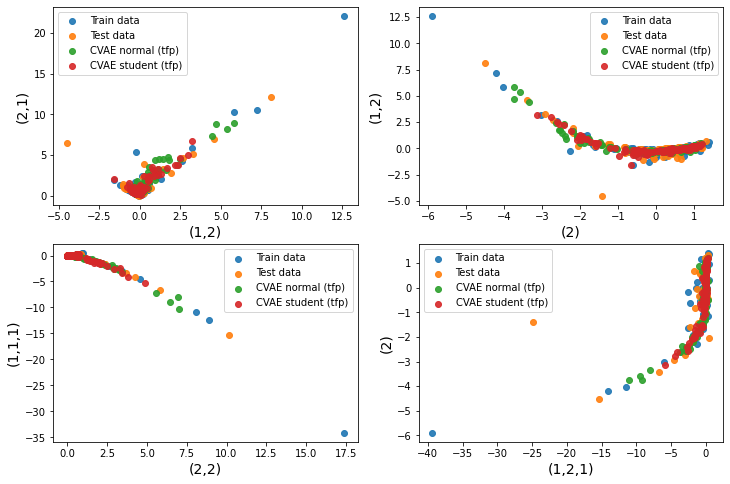

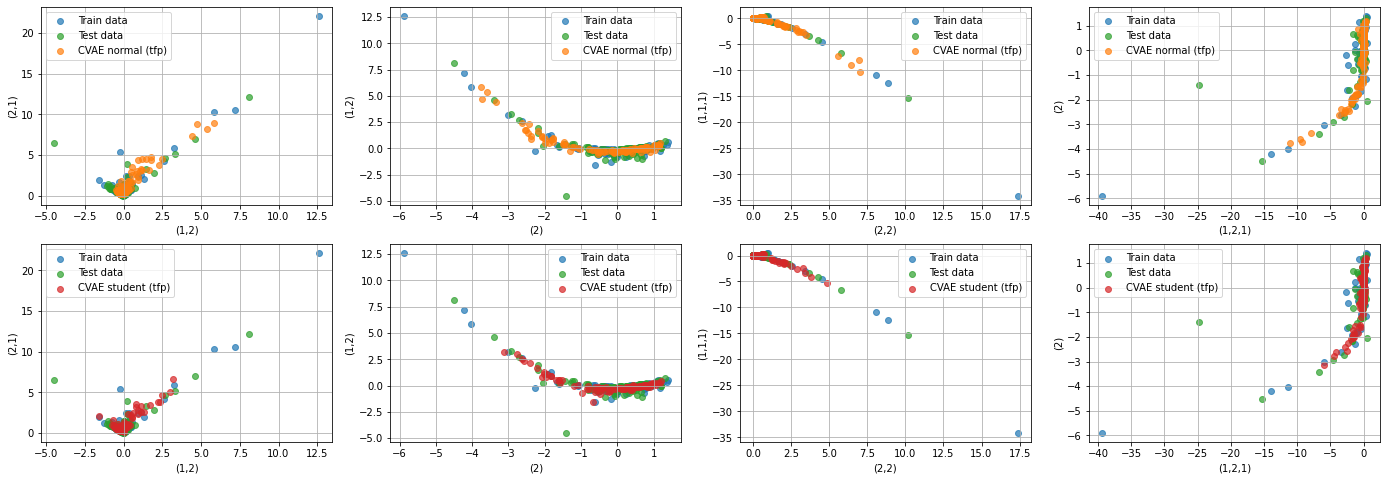

In [12]:
from esig.tosig import sigkeys
keys = sigkeys(2, order).split()
factor = []
for i in keys:
    factor.append((np.ceil((len(i)-2)/2)))
factor = np.array(factor)
PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]
# set_sig = [train_sig, test_sig, generated_sig, generated_sig1, generated_sig2]
# set_name = ["Train data", "Test data", "CVAE normal (keras)", "CVAE normal (tfp)", "CVAE student (tfp)"]
set_sig = [train_sig, test_sig, generated_sig1, generated_sig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)", "CVAE student (tfp)"]
plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)
    for j, signame in enumerate(zip(set_sig, set_name)):
        sig, name = signame
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
plt.show()

f,p=plt.subplots(2,4,figsize=(24,8))
for k, projection in enumerate(PROJECTIONS):
    for i in range(2):
        p[i,k].scatter(train_sig[:, projection[0]], train_sig[:, projection[1]],\
                       label="Train data", alpha = 0.7, color = 'tab:blue')
        p[i,k].scatter(test_sig[:, projection[0]], test_sig[:, projection[1]],\
                       label="Test data", alpha = 0.7, color = 'tab:green')
        if i == 0:
            p[i,k].scatter(generated_sig1[:, projection[0]], generated_sig1[:, projection[1]],\
                         label="CVAE normal (tfp)", alpha = 0.7, color = 'tab:orange')
        else: 
            p[i,k].scatter(generated_sig2[:, projection[0]], generated_sig2[:, projection[1]],\
                         label="CVAE student (tfp)", alpha = 0.7, color = 'tab:red')
        p[i,k].set_xlabel(keys[projection[0]], fontsize=10)
        p[i,k].set_ylabel(keys[projection[1]], fontsize=10)
        p[i,k].legend()
        p[i,k].grid()
plt.show()
#     plt.xticks([])
#     plt.yticks([])

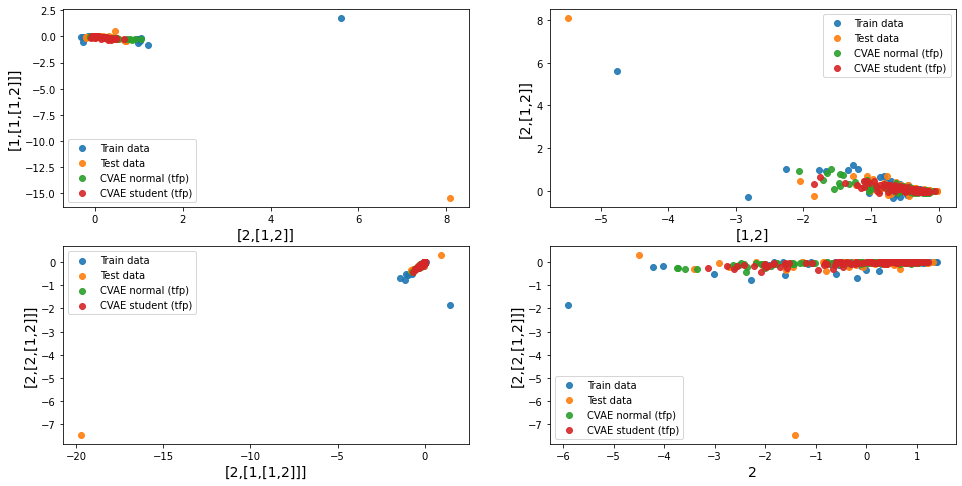

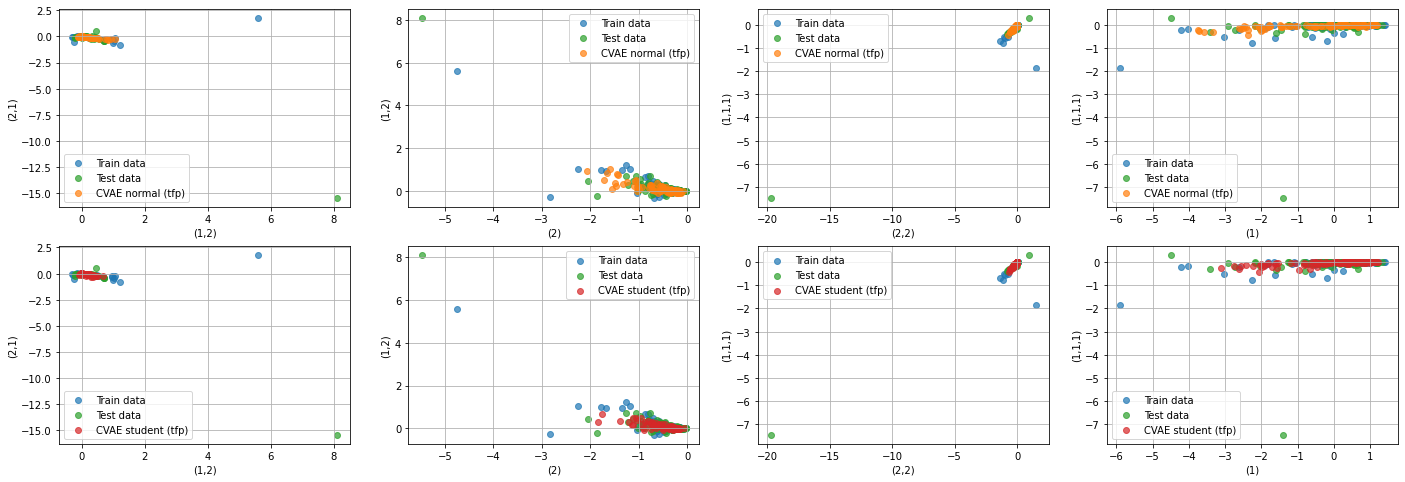

In [13]:
from esig.tosig import logsigkeys
import re

logkeys = logsigkeys(2, order).split()

logfactor = []
for i in logkeys:
    logfactor.append((len(re.sub("\D", "", i))))
logfactor = np.array(logfactor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (1, 7)]

set_logsig = [train_logsig, test_logsig, generated_logsig1, generated_logsig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)", "CVAE student (tfp)"]

plt.figure(figsize=(16, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i+1)
    for sig, name in zip(set_logsig, set_name):
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
        
    plt.xlabel(logkeys[projection[0]], fontsize=14)
    plt.ylabel(logkeys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
plt.show()

f,p=plt.subplots(2,4,figsize=(24,8))
for k, projection in enumerate(PROJECTIONS):
    for i in range(2):
        p[i,k].scatter(train_logsig[:, projection[0]], train_logsig[:, projection[1]],\
                       label="Train data", alpha = 0.7, color = 'tab:blue')
        p[i,k].scatter(test_logsig[:, projection[0]], test_logsig[:, projection[1]],\
                       label="Test data", alpha = 0.7, color = 'tab:green')
        if i == 0:
            p[i,k].scatter(generated_logsig1[:, projection[0]], generated_logsig1[:, projection[1]],\
                         label="CVAE normal (tfp)", alpha = 0.7, color = 'tab:orange')
        else: 
            p[i,k].scatter(generated_logsig2[:, projection[0]], generated_logsig2[:, projection[1]],\
                         label="CVAE student (tfp)", alpha = 0.7, color = 'tab:red')
        p[i,k].set_xlabel(keys[projection[0]], fontsize=10)
        p[i,k].set_ylabel(keys[projection[1]], fontsize=10)
        p[i,k].legend()
        p[i,k].grid()
plt.show()
#     plt.xticks([])
#     plt.yticks([])

## Evaluation

In [14]:
import evaluation
reload(evaluation)

import process_discriminator
reload(process_discriminator)

# phi1 = process_discriminator.T_global(test_sig[1:], generated_sig1,\
#                                      order=4, verbose=False, normalise=True, compute_sigs=False)
# phi2 = process_discriminator.T_global(test_sig[1:], generated_sig2,\
#                                      order=4, verbose=False, normalise=True, compute_sigs=False)
# phi = min(phi1,phi2)



windows1 = _load_rough_bergomi(params, 'M')
sig1 = np.array([_sig(path) for path in tqdm(windows1, desc="Computing signatures")])
windows2 = _load_rough_bergomi(params, 'M')
sig2 = np.array([_sig(path) for path in tqdm(windows2, desc="Computing signatures")])
phi, PHI_X, PHI_Y = process_discriminator.T_global(sig1, sig2, order=4, verbose=True, normalise=True, compute_sigs=False)
phi = min(np.array(PHI_X).mean(),np.array(PHI_Y).mean())
phi


0.2633351795770453


0.9203500258463402

In [15]:
TU0 = []
TU1 = []
TU2 = []
TU3 = []
for i in range(20):
    print(i)
    
    windows1 = _load_rough_bergomi(params, 'M')
    logsig1 = np.array([_logsig(path) for path in tqdm(windows1, desc="Computing log-signatures")])
    sig1 = np.array([_sig(path) for path in tqdm(windows1, desc="Computing signatures")])
    
    windows2 = _load_rough_bergomi(params, 'M')
    logsig2 = np.array([_logsig(path) for path in tqdm(windows2, desc="Computing log-signatures")])
    sig2 = np.array([_sig(path) for path in tqdm(windows2, desc="Computing signatures")])

    scaler_logsig1 = MinMaxScaler(feature_range=(0.00001, 0.99999))
    logsig_transformed1 = scaler_logsig.fit_transform(logsig1)

    scaler_sig1 = MinMaxScaler(feature_range=(0.00001, 0.99999))
    sig_transformed1 = scaler_sig.fit_transform(sig1)

    data1 = logsig_transformed1[1:]   # 1 week forecasting 1 week 
    data_cond1 = logsig_transformed1[:-1] 
    scaler1 = scaler_logsig1

    normalised_generated_normal = model_normal.generate(data_cond1)
    generated_logsig_normal = scaler.inverse_transform(normalised_generated_normal)
    generated_sig_normal = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig_normal)])

    normalised_generated_student = model_student.generate(data_cond1)
    generated_logsig_student = scaler.inverse_transform(normalised_generated_student)
    generated_sig_student = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig_student)])
    
    result, TU = process_discriminator.test_fix(sig1[1:], sig2[1:],\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU0.append(TU)
    
    result, TU = process_discriminator.test_fix(sig1[1:], generated_sig_normal,\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU1.append(TU)
    
    result, TU = process_discriminator.test_fix(sig1[1:], generated_sig_student,\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU2.append(TU)
    
    different = tf.constant(_load_rough_bergomi(params2,'M'))
    
    
    result, TU = process_discriminator.test_fix(tf.constant(windows1), different, order=3, confidence_level=0.99, phi_x = phi)
    TU3.append(TU)
    

0



c: 0.04030256447915187
TU: 0.018433775408596365
m: 99



c: 0.04030256447915187
TU: 4.035733673240154
m: 99



c: 0.04030256447915187
TU: 4.554169036750765
m: 99



c: 0.040100545339935616
TU: 0.34650064938306135
m: 100
1



c: 0.04030256447915187
TU: 0.01733265967640696
m: 99



c: 0.04030256447915187
TU: 4.8176018241895395
m: 99



c: 0.04030256447915187
TU: 4.916550771086122
m: 99



c: 0.040100545339935616
TU: 0.2267662256577645
m: 100
2



c: 0.04030256447915187
TU: 0.01710304300193677
m: 99



c: 0.04030256447915187
TU: 3.6551158940244886
m: 99



c: 0.04030256447915187
TU: 3.805207800536805
m: 99



c: 0.040100545339935616
TU: 0.3266811750455707
m: 100
3



c: 0.04030256447915187
TU: 0.10004926895876931
m: 99



c: 0.04030256447915187
TU: 5.219428839921459
m: 99



c: 0.04030256447915187
TU: 5.43512286551913
m: 99



c: 0.040100545339935616
TU: 0.45452479067325235
m: 100
4



c: 0.04030256447915187
TU: 0.022511878062442925
m: 99



c: 0.04030256447915187
TU: 2.6658657738550975
m: 99



c: 0.04030256447915187
TU: 2.660793574849575
m: 99



c: 0.040100545339935616
TU: 0.3351533064418968
m: 100
5



c: 0.04030256447915187
TU: 0.021134363132313982
m: 99



c: 0.04030256447915187
TU: 4.378202674367903
m: 99



c: 0.04030256447915187
TU: 4.630735250322841
m: 99



c: 0.040100545339935616
TU: 0.2146615918937198
m: 100
6



c: 0.04030256447915187
TU: 0.002677219544905629
m: 99



c: 0.04030256447915187
TU: 1.777467456635276
m: 99



c: 0.04030256447915187
TU: 2.085937394353234
m: 99



c: 0.040100545339935616
TU: 0.3735806505956729
m: 100
7



c: 0.04030256447915187
TU: 0.010743176893034168
m: 99



c: 0.04030256447915187
TU: 4.865401395878661
m: 99



c: 0.04030256447915187
TU: 4.88908262862045
m: 99



c: 0.040100545339935616
TU: 0.23643421747803428
m: 100
8



c: 0.04030256447915187
TU: 0.018327464734971155
m: 99



c: 0.04030256447915187
TU: 4.471738990333436
m: 99



c: 0.04030256447915187
TU: 4.888378735225165
m: 99



c: 0.040100545339935616
TU: 0.2754777113013551
m: 100
9



c: 0.04030256447915187
TU: 0.011525380120279038
m: 99



c: 0.04030256447915187
TU: 5.513512964819525
m: 99



c: 0.04030256447915187
TU: 5.742417934639741
m: 99



c: 0.040100545339935616
TU: 0.1595199707417625
m: 100
10



c: 0.04030256447915187
TU: 0.014544918473746726
m: 99



c: 0.04030256447915187
TU: 5.819179150101237
m: 99



c: 0.04030256447915187
TU: 6.315984334722737
m: 99



c: 0.040100545339935616
TU: 0.1678938889231909
m: 100
11



c: 0.04030256447915187
TU: 0.04773847029892986
m: 99



c: 0.04030256447915187
TU: 4.956761145323078
m: 99



c: 0.04030256447915187
TU: 4.977343307399514
m: 99



c: 0.040100545339935616
TU: 0.18385469075894934
m: 100
12



c: 0.04030256447915187
TU: 0.021308958986388404
m: 99



c: 0.04030256447915187
TU: 4.3280437173701145
m: 99



c: 0.04030256447915187
TU: 5.22468227158457
m: 99



c: 0.040100545339935616
TU: 0.2624265739016671
m: 100
13



c: 0.04030256447915187
TU: 0.023407198166849774
m: 99



c: 0.04030256447915187
TU: 5.077646941543831
m: 99



c: 0.04030256447915187
TU: 5.5382143811475775
m: 99



c: 0.040100545339935616
TU: 0.24000718117286235
m: 100
14



c: 0.04030256447915187
TU: 0.007962434172878563
m: 99



c: 0.04030256447915187
TU: 3.5003313001450373
m: 99



c: 0.04030256447915187
TU: 4.125227391842241
m: 99



c: 0.040100545339935616
TU: 0.24714927007864862
m: 100
15



c: 0.04030256447915187
TU: 0.06802886631004057
m: 99



c: 0.04030256447915187
TU: 4.399022555128752
m: 99



c: 0.04030256447915187
TU: 4.67248970144311
m: 99



c: 0.040100545339935616
TU: 0.2556415371146912
m: 100
16



c: 0.04030256447915187
TU: 0.062316891211718684
m: 99



c: 0.04030256447915187
TU: 4.986960602383817
m: 99



c: 0.04030256447915187
TU: 5.109324933733951
m: 99



c: 0.040100545339935616
TU: 0.23925423192943418
m: 100
17



c: 0.04030256447915187
TU: 0.031126983237910633
m: 99



c: 0.04030256447915187
TU: 4.56914868493657
m: 99



c: 0.04030256447915187
TU: 5.070888519543164
m: 99



c: 0.040100545339935616
TU: 0.30933208893304753
m: 100
18



c: 0.04030256447915187
TU: 0.03982405250251375
m: 99



c: 0.04030256447915187
TU: 3.425098736608266
m: 99



c: 0.04030256447915187
TU: 3.8727231090223944
m: 99



c: 0.040100545339935616
TU: 0.34114231747718193
m: 100
19



c: 0.04030256447915187
TU: 0.015548411911276983
m: 99



c: 0.04030256447915187
TU: 5.071399634293728
m: 99



c: 0.04030256447915187
TU: 5.333530240801522
m: 99



c: 0.040100545339935616
TU: 0.17749465547567667
m: 100


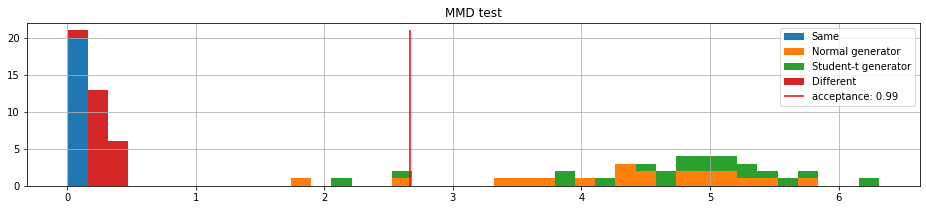

In [27]:
K = 8
m = 100
alpha = 0.5
split = 4*K / np.sqrt(m) * np.sqrt(np.log(1/alpha))

TU = np.array([TU0, TU1, TU2, TU3])
label = ['Same', 'Normal generator', 'Student-t generator', 'Different'] 
plt.figure(figsize = (16,3))
a = plt.hist(TU.T, bins = 40, histtype='bar', stacked=True, label = label)
plt.vlines(split,0,a[0].max(), color = 'r', label = 'acceptance: 0.99')
plt.legend()
plt.grid()
plt.title('MMD test')
# plt.ylabel('$T_{U}^{2}"$')
plt.show()

## From Signature to Path

In [28]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag
from gpsig import kernels
import gpflow

In [29]:
# pip = 0.001
# n_pips = 5 * 10
# n_points = 28
# n_iterations = 100
# n_organisms = 100
# recovered_paths = []
# for i, logsig in enumerate(generated):
#     recovered_paths.append(logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points, pip, n_pips)[0] + 1.)
    

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import signatory
import base
import neural_inverse
from importlib import reload
import time as timing
reload(neural_inverse)

<module 'neural_inverse' from '../src\\neural_inverse.py'>

In [63]:
reload(neural_inverse)
N = 28 - 1 
path = np.array(train_windows)[:,::2,0]
path = path[:,:,None]
time = np.linspace(0,1,N+1)
time_torch = np.tile(time[None,:,None],[100,1,1])
time_torch = torch.Tensor(time_torch)
order = 4
path = np.array([np.concatenate([time[:,None],path0],axis = -1) for path0 in path])

logsig = signatory.logsignature(torch.tensor(path), order)
net, y_recover, logsig_recover = neural_inverse.inverse_multiple_path_time(logsig, N, order, time_torch, 1)

step:  0 loss:  0.39297888427972794
step:  100 loss:  0.0009103245683945715
step:  200 loss:  0.000507373726577498
step:  300 loss:  0.00030902604339644313
step:  400 loss:  0.00022145264665596187
step:  500 loss:  0.0001762831561791245
step:  600 loss:  0.00012920578228658997
step:  700 loss:  0.00011872796676470898
step:  800 loss:  0.00011102714779553935
step:  900 loss:  0.001671155358053511
Finished Training


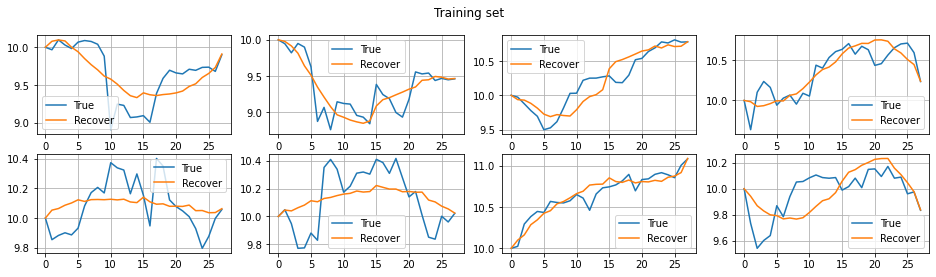

In [64]:
f,p=plt.subplots(2,4,figsize=(16,4)) 
for i in range(2):
    for j in range(4):
        idx = np.random.randint(0,100)
        
        p[i,j].plot(path[idx,:,-1], label = 'True')
        p[i,j].plot(y_recover[idx,:,-1] + 10, label = 'Recover')
        p[i,j].grid()
        p[i,j].legend()
plt.suptitle('Training set')
plt.show()